In [1]:
import sqlite3
import pandas as pd
import plotly.express as px
import sys
from plotly.subplots import make_subplots
import plotly.graph_objects as go

sys.path.append('../')
from functions_env import DB_PATH


conn = sqlite3.connect(DB_PATH)
cursor = conn.cursor()

In [2]:
# Load individuals Main Informations
df_individual = pd.read_sql_query("SELECT * FROM individuals_main_information", conn)
df_individual = df_individual[['individual_wikidata_id', 'birthyear']]

df_individual = df_individual[~df_individual['birthyear'].isna()]
df_individual['decade'] = df_individual['birthyear'].apply(lambda x : int(x/10)*10)

In [3]:
# Load invividuals Regions
df_individual_region = pd.read_sql_query("SELECT * FROM individuals_regions", conn)
df_individual_region = df_individual_region[['individual_wikidata_id', 'region_name']].drop_duplicates()

# Load identifiers meta-data
df_identifiers = pd.read_sql_query("SELECT * FROM identifiers", conn)
df_identifiers['country_name'][df_identifiers['country_name'].isna()]=''
df_identifiers['identifier_name'] = df_identifiers.apply(lambda x : x['identifier_name'] + ' ('  + x['country_name'] + ')' if x['country_name']!='' else x['identifier_name'], axis=1)
df_identifiers = df_identifiers.drop(['country_wikidata_id', 'count_records', 'identifier_url'], axis=1).drop_duplicates()
df_identifiers = df_identifiers.drop(['country_name', 'identifier_name_country'], axis=1).drop_duplicates()


/var/folders/lx/9b13r6ln63jb54_3xlf9b_380000gn/T/ipykernel_7150/808557147.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_identifiers['country_name'][df_identifiers['country_name'].isna()]=''


In [4]:

#df_country =  pd.read_sql_query("SELECT * FROM country_continent", conn)
#df_country = df_country[['country_name', 'continent_name']]
#df_country = df_country.drop_duplicates('country_name', keep='first')
#df_identifiers = pd.merge(df_identifiers, df_country, on = 'country_name', how = 'left')



In [5]:
# Load infirmation about individuals and identifiers
df_ind_identifiers = pd.read_sql_query("SELECT * FROM individual_identifiers", conn)
df_ind_identifiers = df_ind_identifiers.drop('identifier_name', axis=1)
df_ind_identifiers = pd.merge(df_ind_identifiers, df_identifiers, on = 'identifiers_wikidata_id', how = 'left')

# Freebase is now mixed with Google ID
df_ind_identifiers['identifier_name'][df_ind_identifiers['identifier_name']=='Freebase ID'] = 'Google Knowledge Graph ID'
df_ind_identifiers['identifiers_wikidata_id'][df_ind_identifiers['identifiers_wikidata_id']=='P646'] = 'P2671'

# Mix the two GND
df_ind_identifiers['identifier_name'][df_ind_identifiers['identifier_name']=='Deutsche Biographie (GND) ID (Germany)'] = 'GND ID (Germany)'
df_ind_identifiers['identifiers_wikidata_id'][df_ind_identifiers['identifiers_wikidata_id']=='P7902'] = 'P227'

# Clean wrong objects
df_ind_identifiers = df_ind_identifiers[~df_ind_identifiers['individual_name'].str.contains('Painter')]

# Remove superceded
df_ind_identifiers = df_ind_identifiers[~df_ind_identifiers['identifier_name'].str.contains('superceded')]
df_ind_identifiers = df_ind_identifiers[~df_ind_identifiers['identifier_name'].str.contains('obsolete')]

# Drop duplicated after mergeing GND and Freebase
df_ind_identifiers = df_ind_identifiers.drop_duplicates()

In [6]:
# Merge everything

df_final = pd.merge(df_individual, df_ind_identifiers, on = 'individual_wikidata_id')
df_final = pd.merge(df_final, df_individual_region, on = 'individual_wikidata_id')

In [7]:
df_fig = df_final[['individual_wikidata_id', 'decade', 'identifier_name', 'region_name']]
df_fig = df_fig.groupby(['identifier_name', 'region_name', 'decade'])['individual_wikidata_id'].count().rename("score").reset_index()


df_country_id = pd.read_sql_query("SELECT * FROM identifiers", conn)
df_country_id['country_name'][df_country_id['country_name'].isna()]=''
df_country_id['identifier_name'] = df_country_id.apply(lambda x : x['identifier_name'] + ' ('  + x['country_name'] + ')' if x['country_name']!='' else x['identifier_name'], axis=1)
df_country_id = df_country_id[['identifier_name', 'country_name']].drop_duplicates()

df_fig = pd.merge(df_fig, df_country_id, on = 'identifier_name')


/var/folders/lx/9b13r6ln63jb54_3xlf9b_380000gn/T/ipykernel_7150/1539816987.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_country_id['country_name'][df_country_id['country_name'].isna()]=''


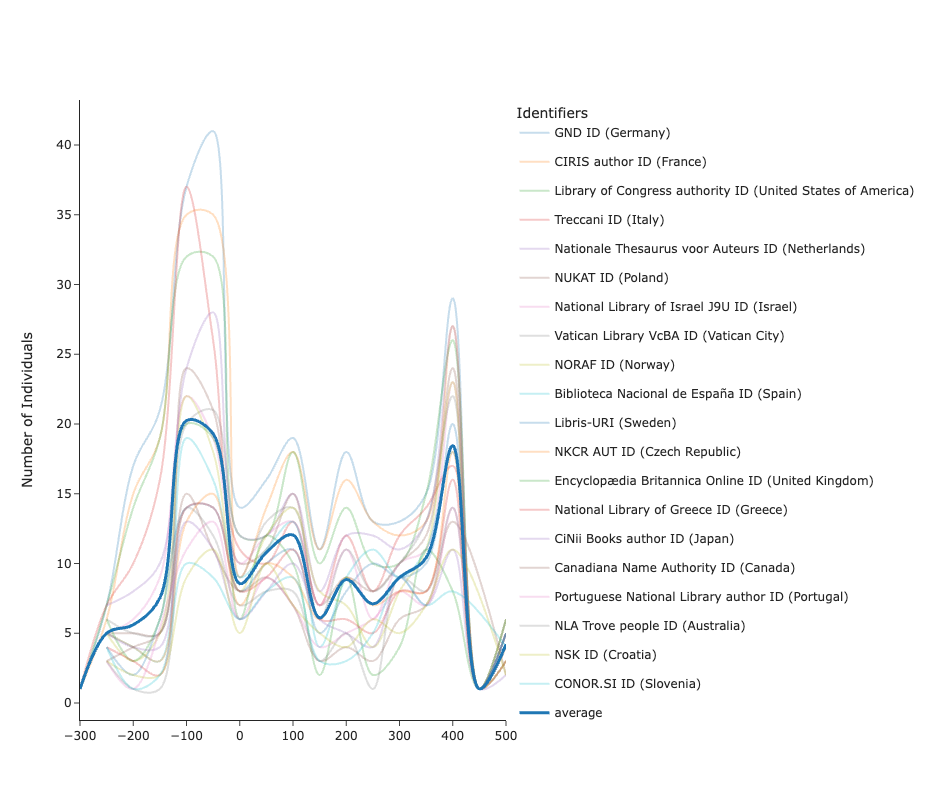

In [19]:
def make_figure(df_graph_bis, region_name, min_decade = 1200, max_decade = 1800, top_identifiers = 5, one_id_country = False):
    
    
    df_fig = df_graph_bis[df_graph_bis['region_name']==region_name]
    df_fig = df_fig[df_fig['decade']<=max_decade]
    df_fig = df_fig[df_fig['decade']>=min_decade]
    
    if one_id_country:
        
        df_fig = df_fig[df_fig['country_name']!='']
        one_id_country = df_fig.groupby(['country_name', 'identifier_name'])['score'].sum().reset_index()
        one_id_country = one_id_country.sort_values(['country_name', 'score'], ascending=(False, False))
        one_id_country = one_id_country.groupby('country_name').head(1)
        one_id_country = list(one_id_country['identifier_name'])
        df_fig = df_fig[df_fig['identifier_name'].isin(one_id_country)]
        
    top_ids = df_fig.groupby(['identifier_name'])['score'].sum().reset_index().sort_values('score', ascending=False)

    #top_ids = top_ids[top_ids['identifier_name']!='all_identifiers']
    top_ids = list(top_ids['identifier_name'][:top_identifiers])
    df_fig = df_fig[df_fig['identifier_name'].isin(top_ids)]
    df_fig_mean = df_fig.groupby(['decade'])['score'].mean().reset_index()
    df_fig_mean['identifier_name'] = 'average'

    #df_fig = pd.concat([df_fig, df_fig_mean])

    fig = px.line(df_fig, x = 'decade', y = 'score', color = 'identifier_name',
                  width = 1200, 
                  height = 600, 
                  title = region_name, 
                  template = 'simple_white',
                  category_orders={'identifier_name': top_ids}, line_shape='spline')


    #fig.update_layout(legend=dict(title=dict(text='Top 5 Immaterial Production')))
    fig.update_traces(opacity=0.25)

    fig2 = px.line(df_fig_mean, x = 'decade', y = 'score',color = 'identifier_name',
              width = 1200, 
              height = 600, 
              title = region_name, 
              template = 'simple_white', line_shape='spline')

    fig2.update_traces(line=dict(width=3))
    fig3 = go.Figure(data=fig.data + fig2.data)
    fig3.update_layout(xaxis_title='', yaxis_title='Number of Individuals',  
                       template = 'simple_white',  
                       width = 1300, 
                       height = 800,
                      title = '')

# Update the layout with the category order


    #ig3.for_each_trace(lambda t: t.update(name=legend_order.index(t.name)))
    fig3.update_layout(legend=dict(title=dict(text='Identifiers')))
    #fig3.update_layout(category_orders={'Identifiers': top_ids})
    fig3.update_layout(xaxis=dict(dtick=100))

    return fig3, df_fig



df_fig_fifty = df_fig.copy()
df_fig_fifty['decade'] = df_fig_fifty['decade'].apply(lambda x : round(x/50)*50)
df_fig_fifty['decade'] = df_fig_fifty['decade'].apply(lambda x : round(x/50)*50)
df_fig_fifty = df_fig_fifty.groupby(['identifier_name', 'country_name', 'region_name', 'decade'])['score'].sum().reset_index()

region_name = 'Italy'

fig_italy, df_fig_italy = make_figure(df_fig_fifty, 
                   region_name = region_name, 
                   min_decade = -300, 
                   max_decade = 500, 
                   top_identifiers = 20,
                  one_id_country = True)

fig_italy.show()
fig_italy.write_image(f"figures/italy_identifiers.png", scale=7)

In [16]:
df_corr = df_fig_italy.pivot(index ='decade', columns = 'identifier_name', values = 'score')
df_corr = df_corr.fillna(0)
df_corr.corr().stack().mean()

0.8841142962007862

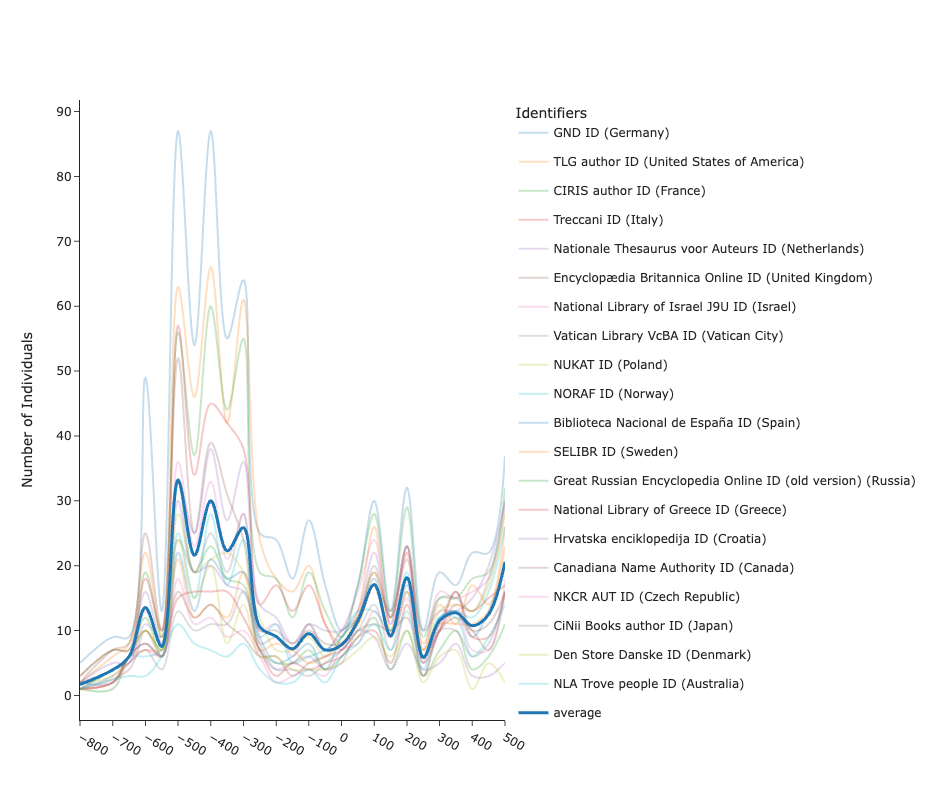

In [20]:
fig_greek, df_fig_greek = make_figure(df_fig_fifty, region_name = 'Greek World', min_decade = -800, max_decade = 500, top_identifiers = 20,
                  one_id_country = True)

fig_greek.write_image(f"figures/greek_identifiers.png", scale=7)
fig_greek.show()

In [18]:
df_corr = df_fig_greek.pivot(index ='decade', columns = 'identifier_name', values = 'score')
df_corr = df_corr.fillna(0)
df_corr.corr().stack().mean()

0.799308659853217

## Count catalogs per country and continents

In [ ]:
test = df_fig[df_fig['region_name'].isin(['Italy', 'Greek World'])]
test = test[(test['decade']>=-800)&(test['decade']<=500)]
len(set(test.identifier_name))

test = pd.merge(df_identifiers, test, on = 'identifier_name')

df_identifiers_2 = pd.read_sql_query("SELECT * FROM identifiers", conn)
df_identifiers_2 = df_identifiers_2[['identifiers_wikidata_id', 'country_name']].dropna()

test = pd.merge(test, df_identifiers_2, on = 'identifiers_wikidata_id')
df_country =  pd.read_sql_query("SELECT * FROM country_continent", conn)
df_country = df_country[['country_name', 'continent_name']]
test = pd.merge(df_country, test, on = 'country_name')
set(test.continent_name)